In [38]:
options(warn =-1, repr.plot.width=15, repr.plot.height=9)
# ## 패키지 설치
library(dplyr)
library(stringr)
library(ggplot2)
library(gridExtra)
library(scales)
library(randomForest)
library(lubridate)
library(caret)


In [39]:
.libPaths()

[1] "/Users/ohkang/miniforge3/envs/RBASE/lib/R/library"

In [40]:
raw_data_employed <- read.csv("./data/disabled_employed_rawdata_2020.csv")


In [41]:
head(raw_data_employed)
str(raw_data_employed)
summary(raw_data_employed)

,순번,취업일자,연령,장애유형,중증여부,근무지역,취업직종대분류
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,1,2020-01-01,65,시각장애,중증,경북 경산시,경영·행정·사무직
2,2,2020-01-01,61,시각장애,중증,경북 고령군,경영·행정·사무직
3,3,2020-01-01,53,시각장애,경증,경북 의성군,경영·행정·사무직
4,4,2020-01-01,64,시각장애,중증,경북 성주군,경영·행정·사무직
5,5,2020-01-01,53,시각장애,경증,경북 군위군,경영·행정·사무직
6,6,2020-01-01,60,시각장애,중증,경북 영천시,경영·행정·사무직


'data.frame':	31646 obs. of  7 variables:
 $ 순번          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ 취업일자      : chr  "2020-01-01" "2020-01-01" "2020-01-01" "2020-01-01" ...
 $ 연령          : int  65 61 53 64 53 60 63 40 56 62 ...
 $ 장애유형      : chr  "시각장애" "시각장애" "시각장애" "시각장애" ...
 $ 중증여부      : chr  "중증" "중증" "경증" "중증" ...
 $ 근무지역      : chr  "경북 경산시" "경북 고령군" "경북 의성군" "경북 성주군" ...
 $ 취업직종대분류: chr  "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" ...


      순번         취업일자              연령         장애유형        
 Min.   :    1   Length:31646       Min.   :17.00   Length:31646      
 1st Qu.: 7912   Class :character   1st Qu.:25.00   Class :character  
 Median :15824   Mode  :character   Median :38.00   Mode  :character  
 Mean   :15824                      Mean   :40.71                     
 3rd Qu.:23735                      3rd Qu.:55.00                     
 Max.   :31646                      Max.   :87.00                     
   중증여부           근무지역         취업직종대분류    
 Length:31646       Length:31646       Length:31646      
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         

In [42]:
### refined_data_연령& 연령대 컬럼 만들기
refined_data <- subset(raw_data_employed, select =-순번)
refined_data$근무지역 <- as.character(refined_data$근무지역)
refined_data$근무지역 <- factor(refined_data$근무지역)
rownames(refined_data) <- c()
refined_data <- subset(refined_data, 연령 >= 20 & 연령 < 80)
refined_data$연령대 <- cut(refined_data$연령, breaks = seq(10, 80, by = 10), labels = c("10","20","30","40","50","60","70"), right = FALSE)

In [43]:
table(refined_data$연령대)


   10    20    30    40    50    60    70 
    0 10042  5174  4692  4792  4292  1288 

In [44]:
### 100명 이하인 직업군 지우기
refined_data_filtered <- subset(refined_data, !(취업직종대분류 %in% c("건설·채굴직","예술·디자인·방송직","건설·채굴 연구개발직 및 공학기술직", "자연·생명과학 연구직", "법률직", "여행·숙박·오락 서비스직", "인문·사회과학 연구직", "자연·생명과학 연구직", "제조 연구개발직 및 공학기술직", "정보통신 설치·정비직")))


In [45]:
### 장애를 세분화 하기
refined_data_filtered$장애유형_중증여부 <- paste(refined_data_filtered$장애유형, refined_data_filtered$중증여부, sep = "-")
table(refined_data_filtered$장애유형_중증여부)


      간장애-경증       간장애-중증     국가유공-경증     국가유공-중증 
               87                 2                92                20 
  뇌병변장애-경증   뇌병변장애-중증   뇌전증장애-경증   뇌전증장애-중증 
              860              1426                90                26 
    시각장애-경증     시각장애-중증     신장장애-경증     신장장애-중증 
             1506              1516               258               418 
    심장장애-경증     심장장애-중증     안면장애-경증     안면장애-중증 
               16                88                36                 7 
    언어장애-경증     언어장애-중증   자폐성장애-경증   자폐성장애-중증 
              203                32                 5               913 
장루요루장애-경증 장루요루장애-중증     정신장애-경증     정신장애-중증 
               47                 4                 9              1733 
    지적장애-경증     지적장애-중증     지체장애-경증     지체장애-중증 
               25              9217              5812              2721 
    청각장애-경증     청각장애-중증   호흡기장애-경증   호흡기장애-중증 
             1101              1495                 5                55 

In [46]:
refined_data_filtered=na.omit(refined_data_filtered)
refined_data_filtered$장애유형_중증여부 <- factor(refined_data_filtered$장애유형_중증여부)

`summarise()` has grouped output by '취업직종대분류'. You can override using
the `.groups` argument.


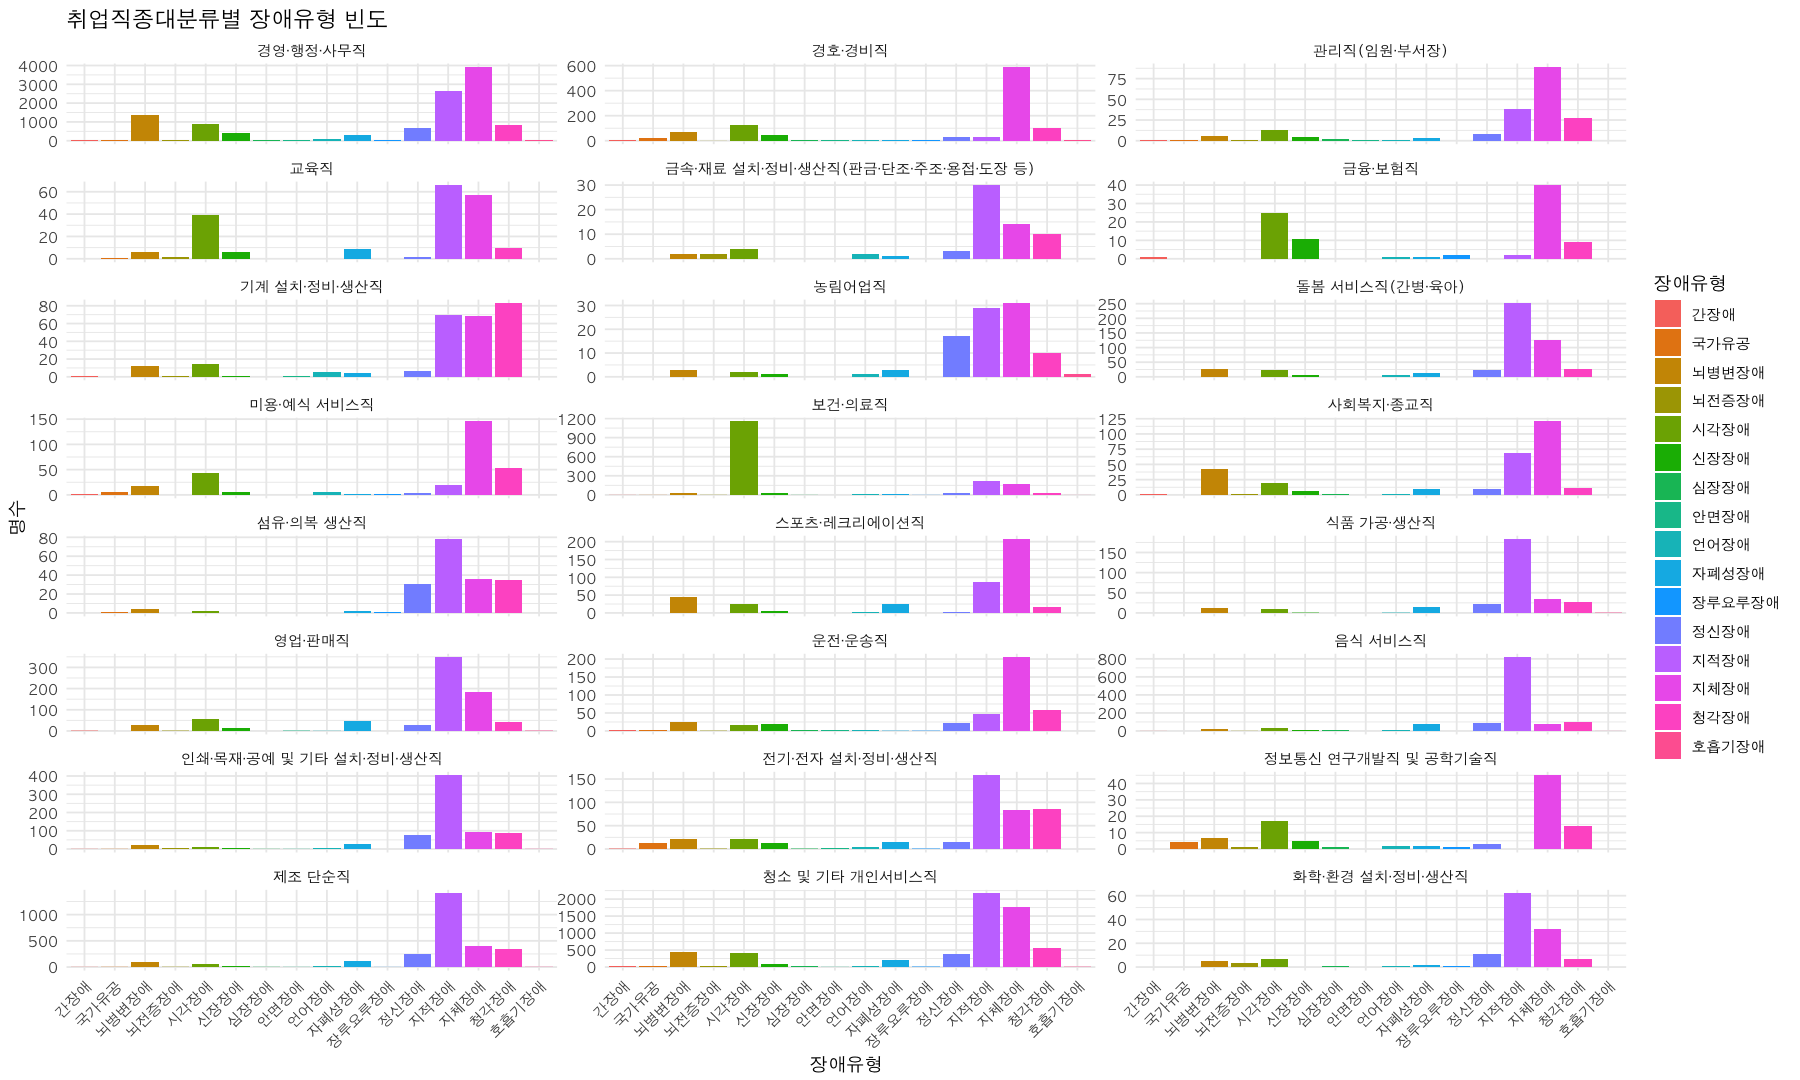

In [47]:
# 취업직종대분류별 연령대 빈도 계산
disable_freq_by_job_category <- refined_data_filtered %>%
  group_by(취업직종대분류, 장애유형) %>%
  summarise(count = n())

# ggplot2를 사용하여 그래프 그리기 (그리드 레이아웃)
disable_freq_by_job_category <- ggplot(disable_freq_by_job_category, aes(x = 장애유형, y = count, fill = 장애유형)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "장애유형", y = "명수", title = "취업직종대분류별 장애유형 빈도") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(family = "AppleGothic")) +
  facet_wrap(~ 취업직종대분류, ncol = 3, scales = "free_y")  # scales = "free_y"로 y축 범위 개별 설정

print(disable_freq_by_job_category)

In [48]:
# 건설·채굴직에 해당하는 데이터만 걸러내기
subset_construction_mining <- subset(refined_data_filtered, 취업직종대분류 == "건설·채굴직")

# 연령대 별로 빈도 계산
table(subset_construction_mining$연령대)


10 20 30 40 50 60 70 
 0  0  0  0  0  0  0 

`summarise()` has grouped output by '취업직종대분류'. You can override using
the `.groups` argument.


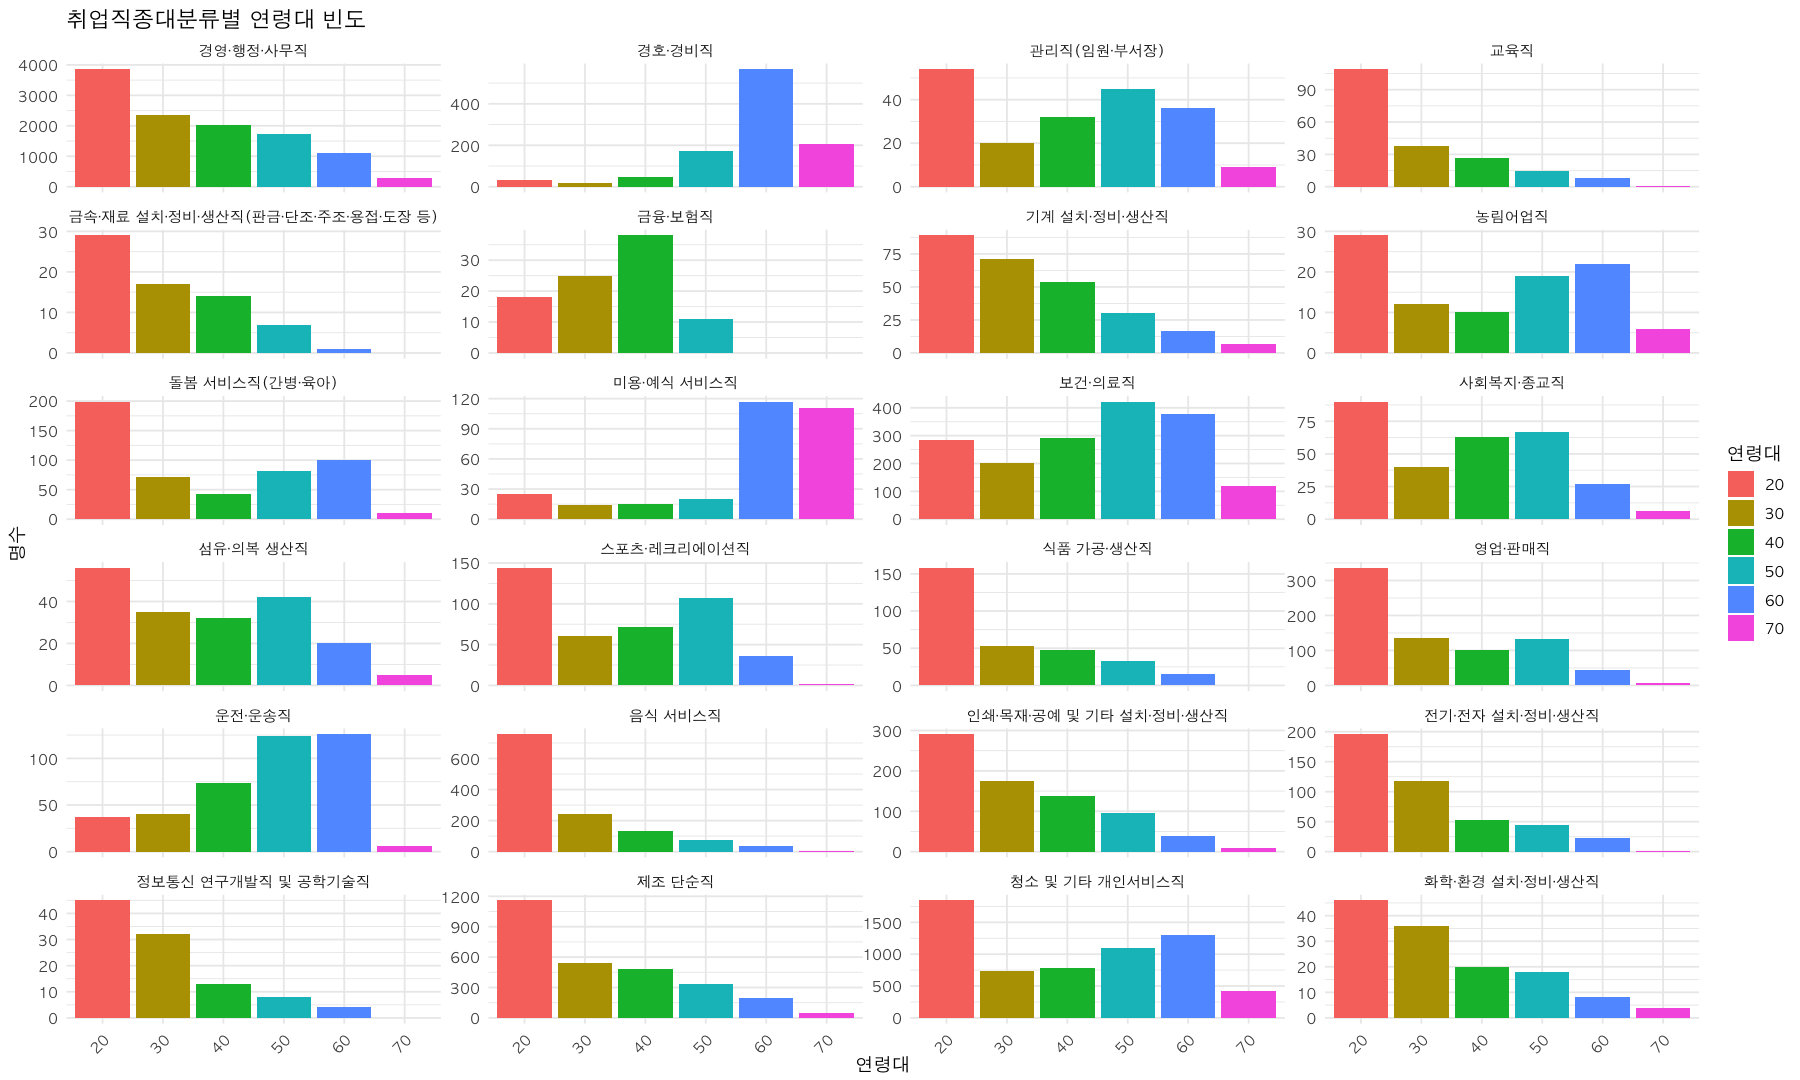

In [49]:
# 취업직종대분류별 연령대 빈도 계산
age_freq_by_job_category <- refined_data_filtered %>%
  group_by(취업직종대분류, 연령대) %>%
  summarise(count = n())

# ggplot2를 사용하여 그래프 그리기 (그리드 레이아웃)
age_freq_by_job_category <- ggplot(age_freq_by_job_category, aes(x = 연령대, y = count, fill = 연령대)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "연령대", y = "명수", title = "취업직종대분류별 연령대 빈도") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(family = "AppleGothic")) +
  facet_wrap(~ 취업직종대분류, ncol = 4, scales = "free_y")  # scales = "free_y"로 y축 범위 개별 설정

print(age_freq_by_job_category)

`summarise()` has grouped output by '취업직종대분류'. You can override using
the `.groups` argument.


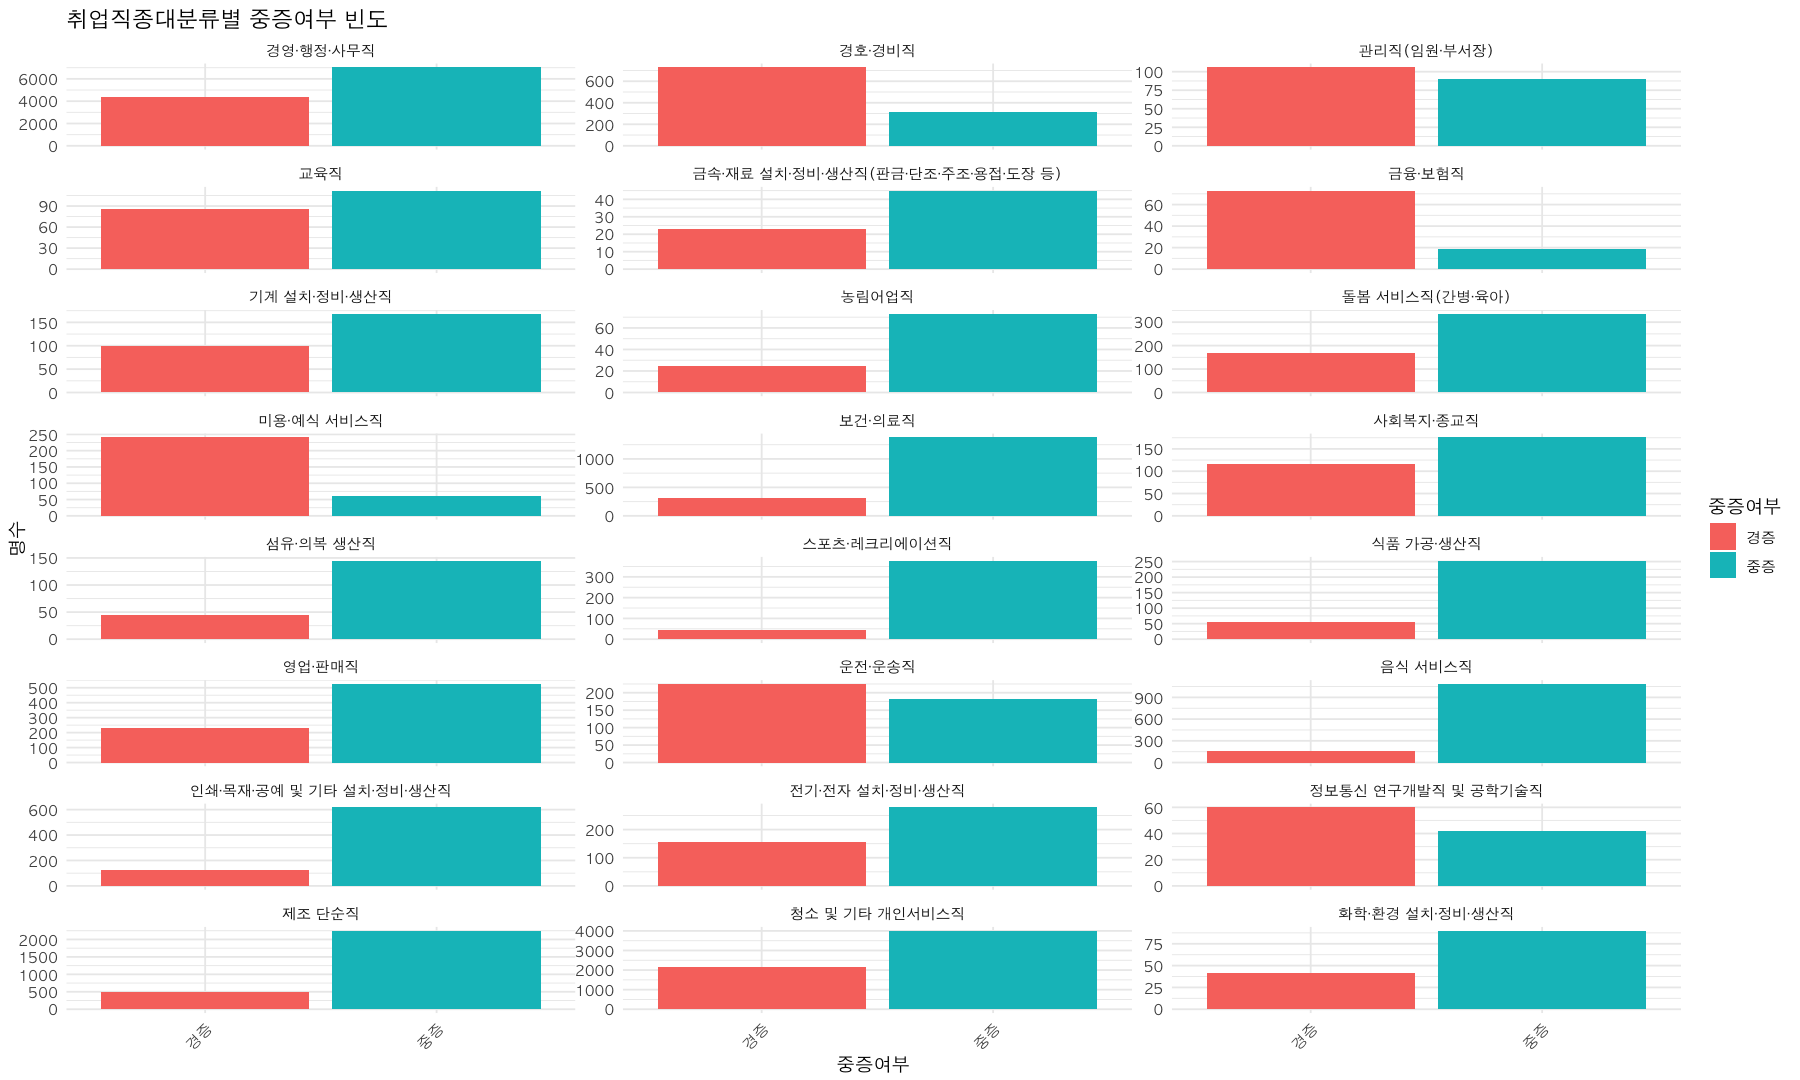

In [50]:
# 취업직종대분류별 연령대 빈도 계산
stress_freq_by_job_category <- refined_data_filtered %>%
  group_by(취업직종대분류,중증여부 ) %>%
  summarise(count = n())

# ggplot2를 사용하여 그래프 그리기 (그리드 레이아웃)
p3 <- ggplot(stress_freq_by_job_category, aes(x = 중증여부, y = count, fill = 중증여부)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "중증여부", y = "명수", title = "취업직종대분류별 중증여부 빈도") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(family = "AppleGothic")) +
  facet_wrap(~ 취업직종대분류, ncol = 3, scales = "free_y")  # scales = "free_y"로 y축 범위 개별 설정

print(p3)

`summarise()` has grouped output by '취업직종대분류'. You can override using
the `.groups` argument.


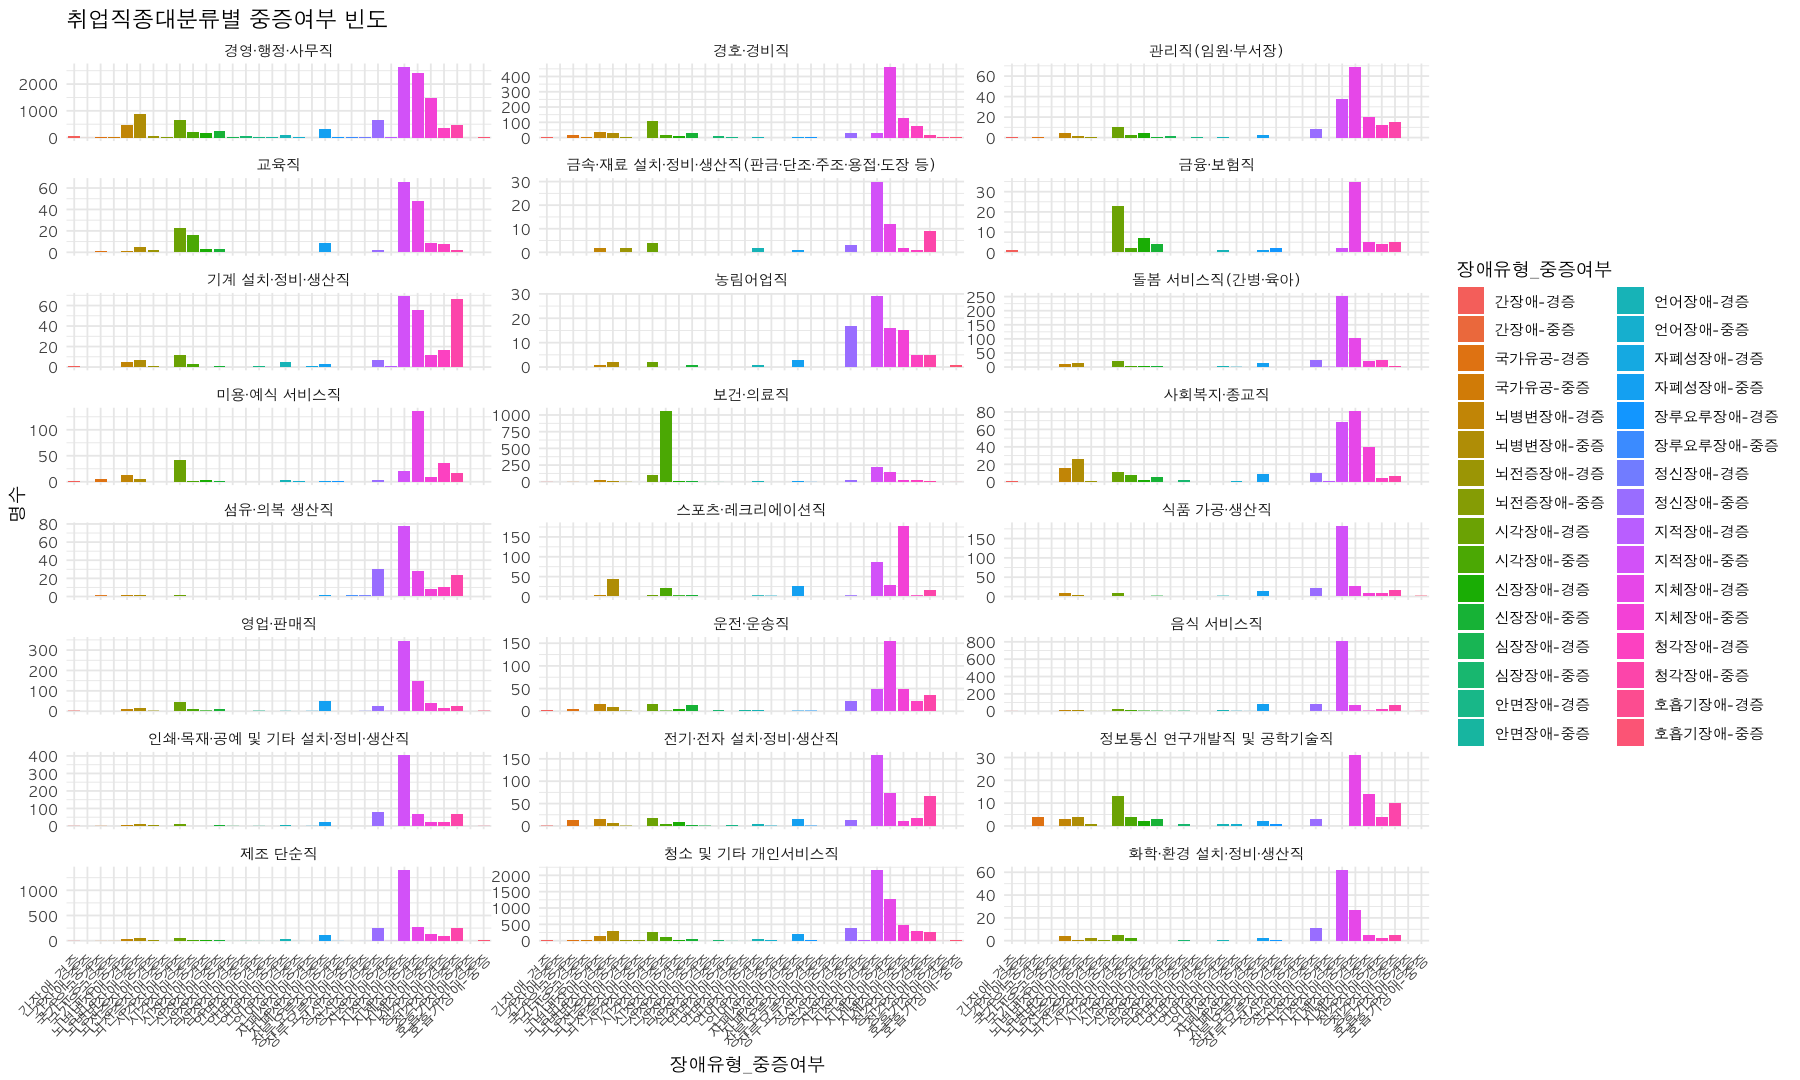

In [51]:
# 취업직종대분류별 장애유형_중증여부 빈도 계산
stress_freq_by_job_category <- refined_data_filtered %>%
  group_by(취업직종대분류,장애유형_중증여부 ) %>%
  summarise(count = n())

# ggplot2를 사용하여 그래프 그리기 (그리드 레이아웃)
p4 <- ggplot(stress_freq_by_job_category, aes(x = 장애유형_중증여부, y = count, fill = 장애유형_중증여부)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "장애유형_중증여부", y = "명수", title = "취업직종대분류별 중증여부 빈도") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(family = "AppleGothic")) +
  facet_wrap(~ 취업직종대분류, ncol = 3, scales = "free_y")  # scales = "free_y"로 y축 범위 개별 설정

print(p4)

In [52]:
### major 5 시각, 정신,지적,지체 청각만 남기기
refined_data_filtered_major5 <- subset(refined_data_filtered, 장애유형 %in% c("시각장애","정신장애","지적장애","지체장애","청각장애"))
refined_data_filtered_major5$연령대 <- as.numeric(refined_data_filtered_major5$연령대)
summary(refined_data_filtered_major5)
str(refined_data_filtered_major5)
table(refined_data_filtered_major5$취업직종대분류)

   취업일자              연령         장애유형           중증여부        
 Length:25135       Min.   :20.00   Length:25135       Length:25135      
 Class :character   1st Qu.:26.00   Class :character   Class :character  
 Mode  :character   Median :39.00   Mode  :character   Mode  :character  
                    Mean   :41.57                                        
                    3rd Qu.:55.00                                        
                    Max.   :79.00                                        
                                                                         
          근무지역     취업직종대분류         연령대          장애유형_중증여부
 서울 송파구  :  686   Length:25135       Min.   :2.000   지적장애-중증:9217   
 서울 강남구  :  531   Class :character   1st Qu.:2.000   지체장애-경증:5812   
 서울 중구    :  531   Mode  :character   Median :3.000   지체장애-중증:2721   
 서울 영등포구:  518                      Mean   :3.742   정신장애-중증:1733   
 제주 제주시  :  408                      3rd Qu.:5.000   시각장애-중증:1516   
 서울 종로구  :  387    

'data.frame':	25135 obs. of  8 variables:
 $ 취업일자         : chr  "2020-01-01" "2020-01-01" "2020-01-01" "2020-01-01" ...
 $ 연령             : int  65 61 53 64 53 60 63 40 56 62 ...
 $ 장애유형         : chr  "시각장애" "시각장애" "시각장애" "시각장애" ...
 $ 중증여부         : chr  "중증" "중증" "경증" "중증" ...
 $ 근무지역         : Factor w/ 271 levels "","강원 강릉시",..: 98 100 115 107 102 112 109 120 19 18 ...
 $ 취업직종대분류   : chr  "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" ...
 $ 연령대           : num  6 6 5 6 5 6 6 4 5 6 ...
 $ 장애유형_중증여부: Factor w/ 32 levels "간장애-경증",..: 10 10 9 10 9 10 10 10 28 10 ...



                                       경영·행정·사무직 
                                                   8961 
                                            경호·경비직 
                                                    879 
                                    관리직(임원·부서장) 
                                                    175 
                                                 교육직 
                                                    174 
금속·재료 설치·정비·생산직(판금·단조·주조·용접·도장 등) 
                                                     61 
                                            금융·보험직 
                                                     76 
                                  기계 설치·정비·생산직 
                                                    243 
                                             농림어업직 
                                                     89 
                               돌봄 서비스직(간병·육아) 
                                                    452 
                                     미용·예식 서비스직

In [53]:
# 취업직종대분류 값들의 빈도수 계산
job_category_freq <- table(refined_data_filtered_major5$취업직종대분류)

# 빈도수가 120개 이하인 취업직종대분류 값들 필터링
filtered_job_category <- names(job_category_freq[job_category_freq >= 120])

# 120개 이하인 취업직종대분류 값들만 보기
refined_data_filtered_major5_subset <- subset(refined_data_filtered_major5, 취업직종대분류 %in% filtered_job_category)
table(refined_data_filtered_major5_subset$장애유형)


시각장애 정신장애 지적장애 지체장애 청각장애 
    2967     1708     9119     8371     2546 

`summarise()` has grouped output by '취업직종대분류'. You can override using
the `.groups` argument.


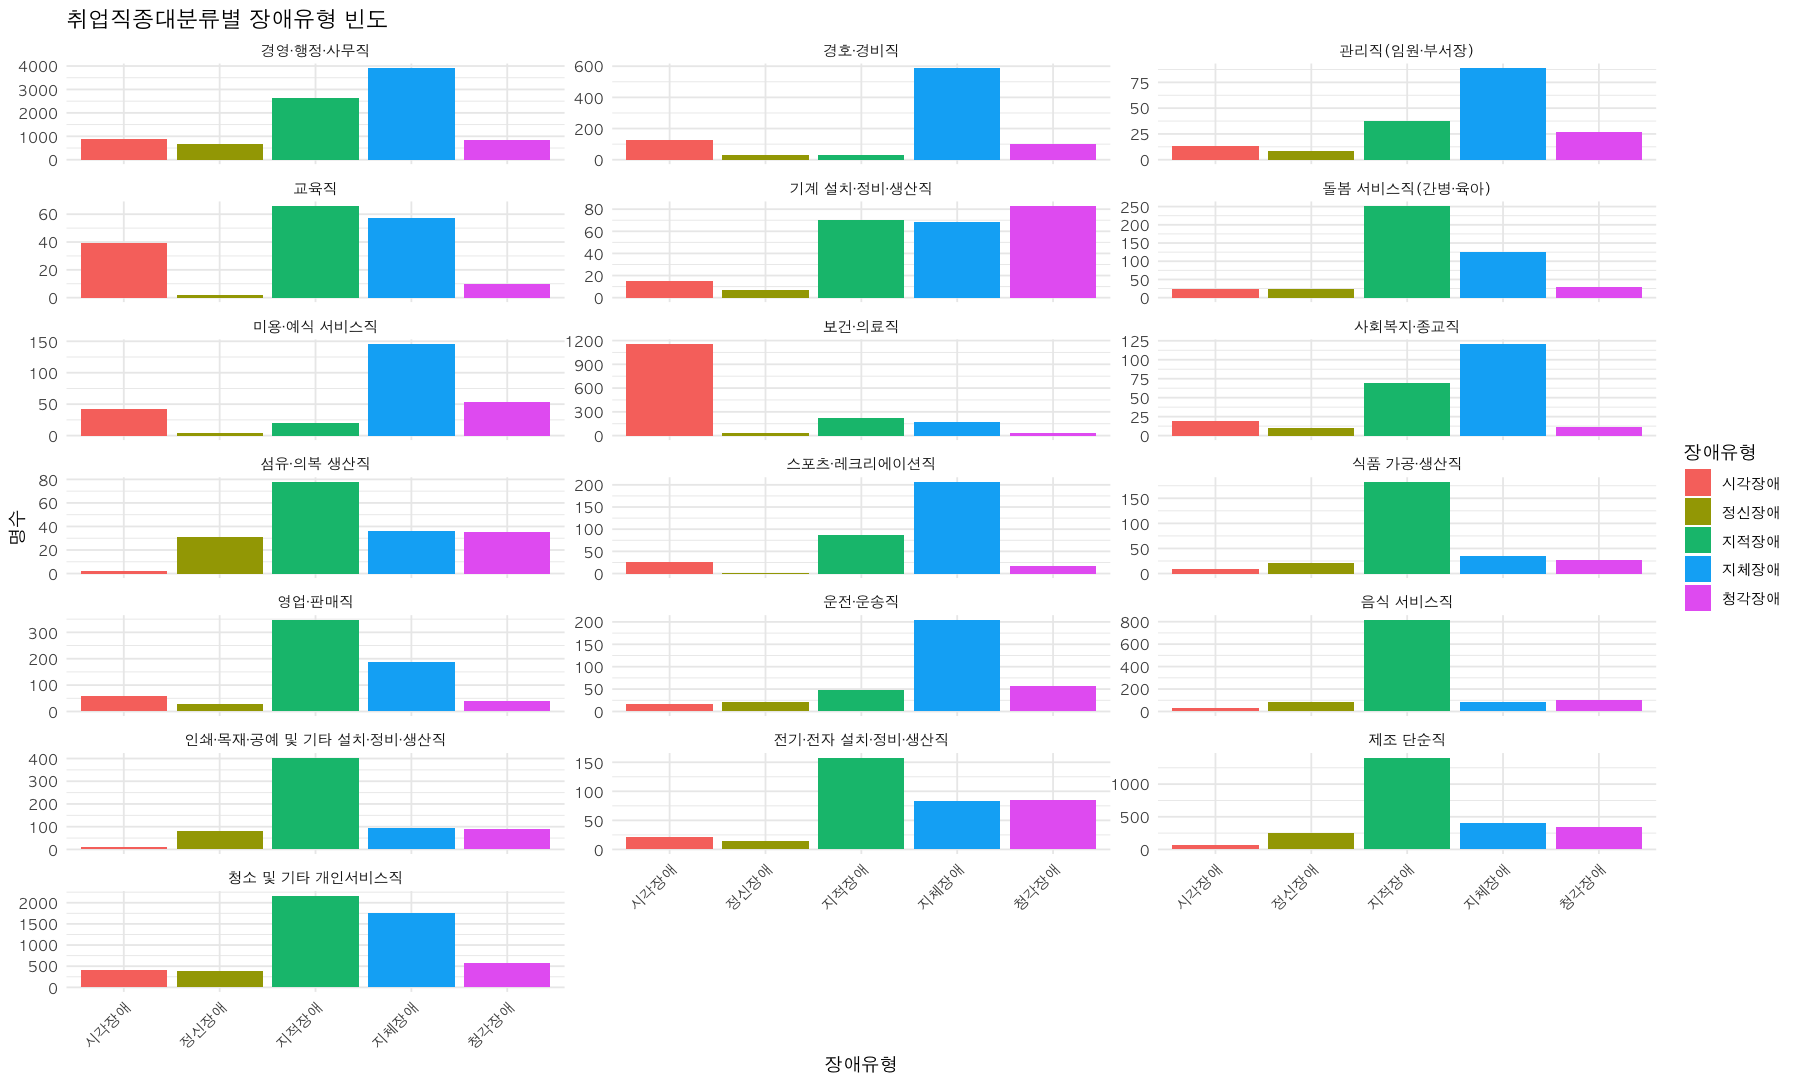

In [54]:
# 취업직종대분류별 연령대 빈도 계산
disable_freq_by_job_category_filtered <- refined_data_filtered_major5_subset %>%
  group_by(취업직종대분류, 장애유형) %>%
  summarise(count = n())

# ggplot2를 사용하여 그래프 그리기 (그리드 레이아웃)
disable_freq_by_job_category_filtered <- ggplot(disable_freq_by_job_category_filtered, aes(x = 장애유형, y = count, fill = 장애유형)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "장애유형", y = "명수", title = "취업직종대분류별 장애유형 빈도") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(family = "AppleGothic")) +
  facet_wrap(~ 취업직종대분류, ncol = 3, scales = "free_y")  # scales = "free_y"로 y축 범위 개별 설정

print(disable_freq_by_job_category_filtered)

`summarise()` has grouped output by '취업직종대분류'. You can override using
the `.groups` argument.


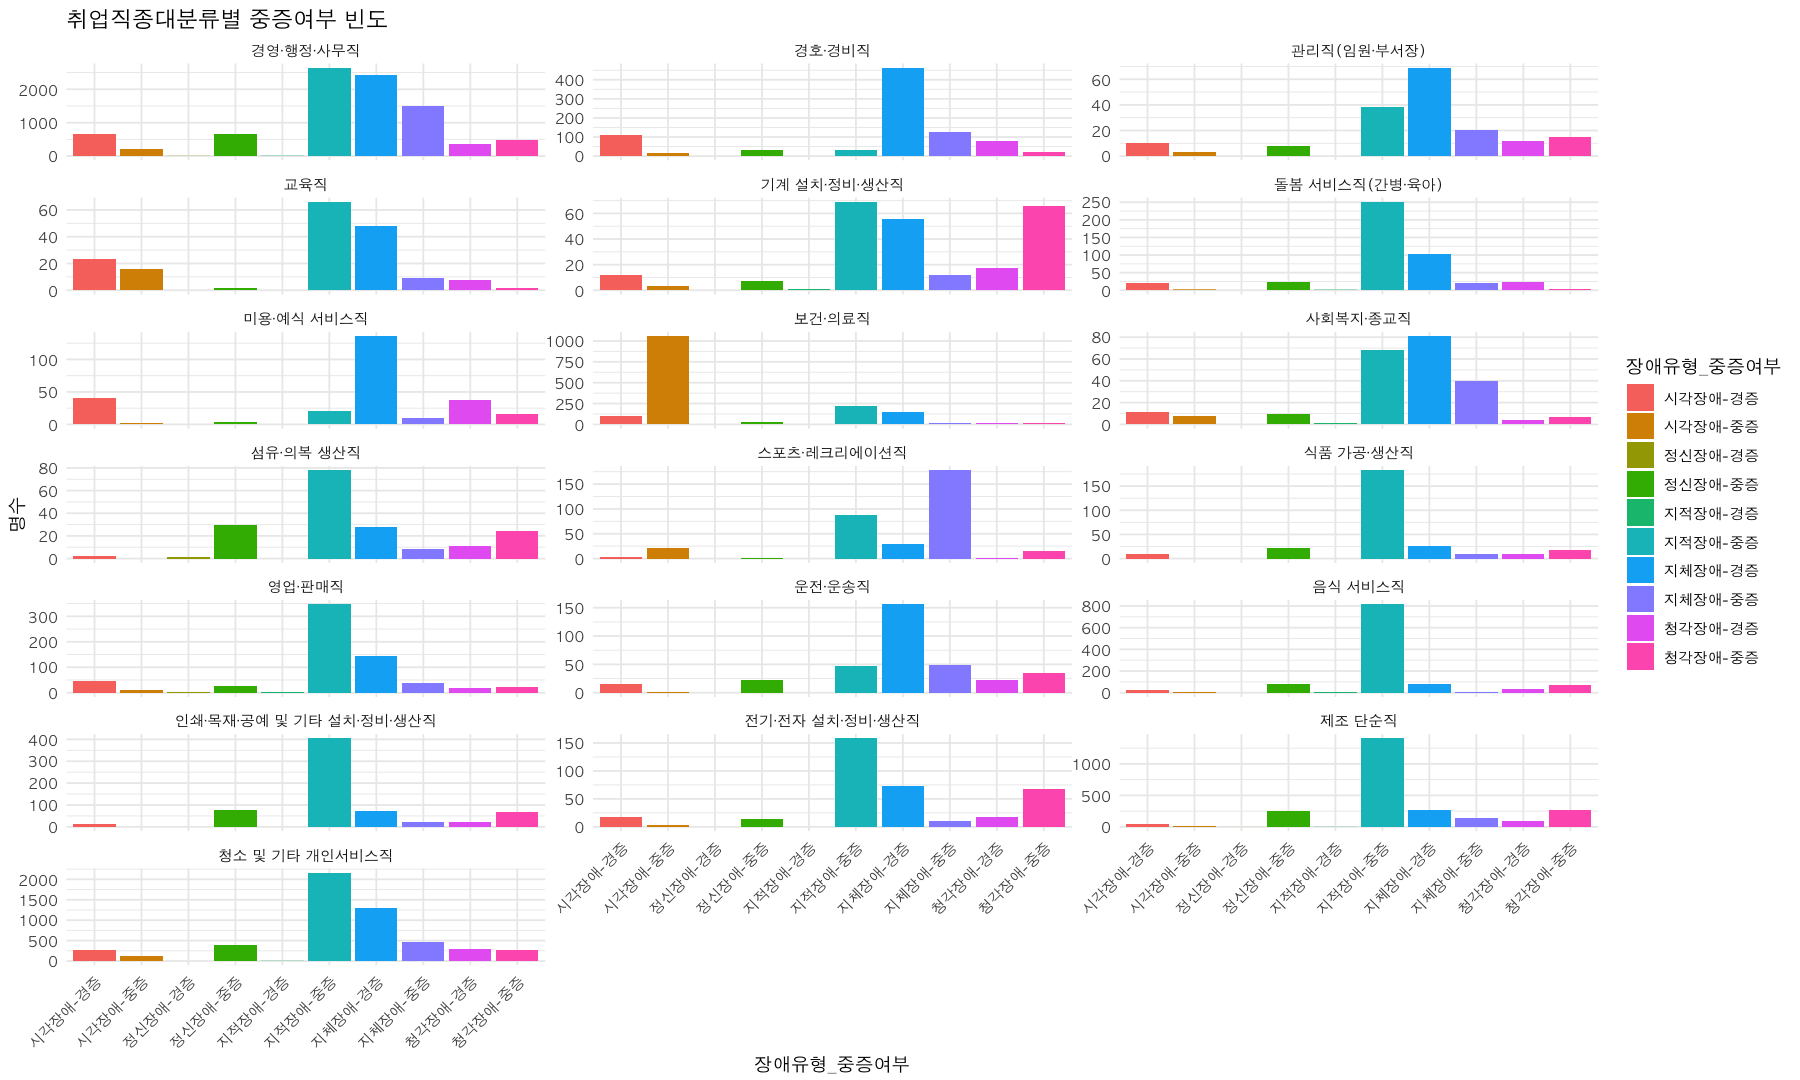

In [55]:
# 취업직종대분류별 장애유형_중증여부 빈도 계산
stress_freq_by_job_category_filtered <- refined_data_filtered_major5_subset %>%
  group_by(취업직종대분류,장애유형_중증여부) %>%
  summarise(count = n())

# ggplot2를 사용하여 그래프 그리기 (그리드 레이아웃)
stress_freq_by_job_category_filtered <- ggplot(stress_freq_by_job_category_filtered, aes(x = 장애유형_중증여부, y = count, fill = 장애유형_중증여부)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "장애유형_중증여부", y = "명수", title = "취업직종대분류별 중증여부 빈도") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(family = "AppleGothic")) +
  facet_wrap(~ 취업직종대분류, ncol = 3, scales = "free_y")  # scales = "free_y"로 y축 범위 개별 설정

print(stress_freq_by_job_category_filtered)

`summarise()` has grouped output by '취업직종대분류'. You can override using
the `.groups` argument.


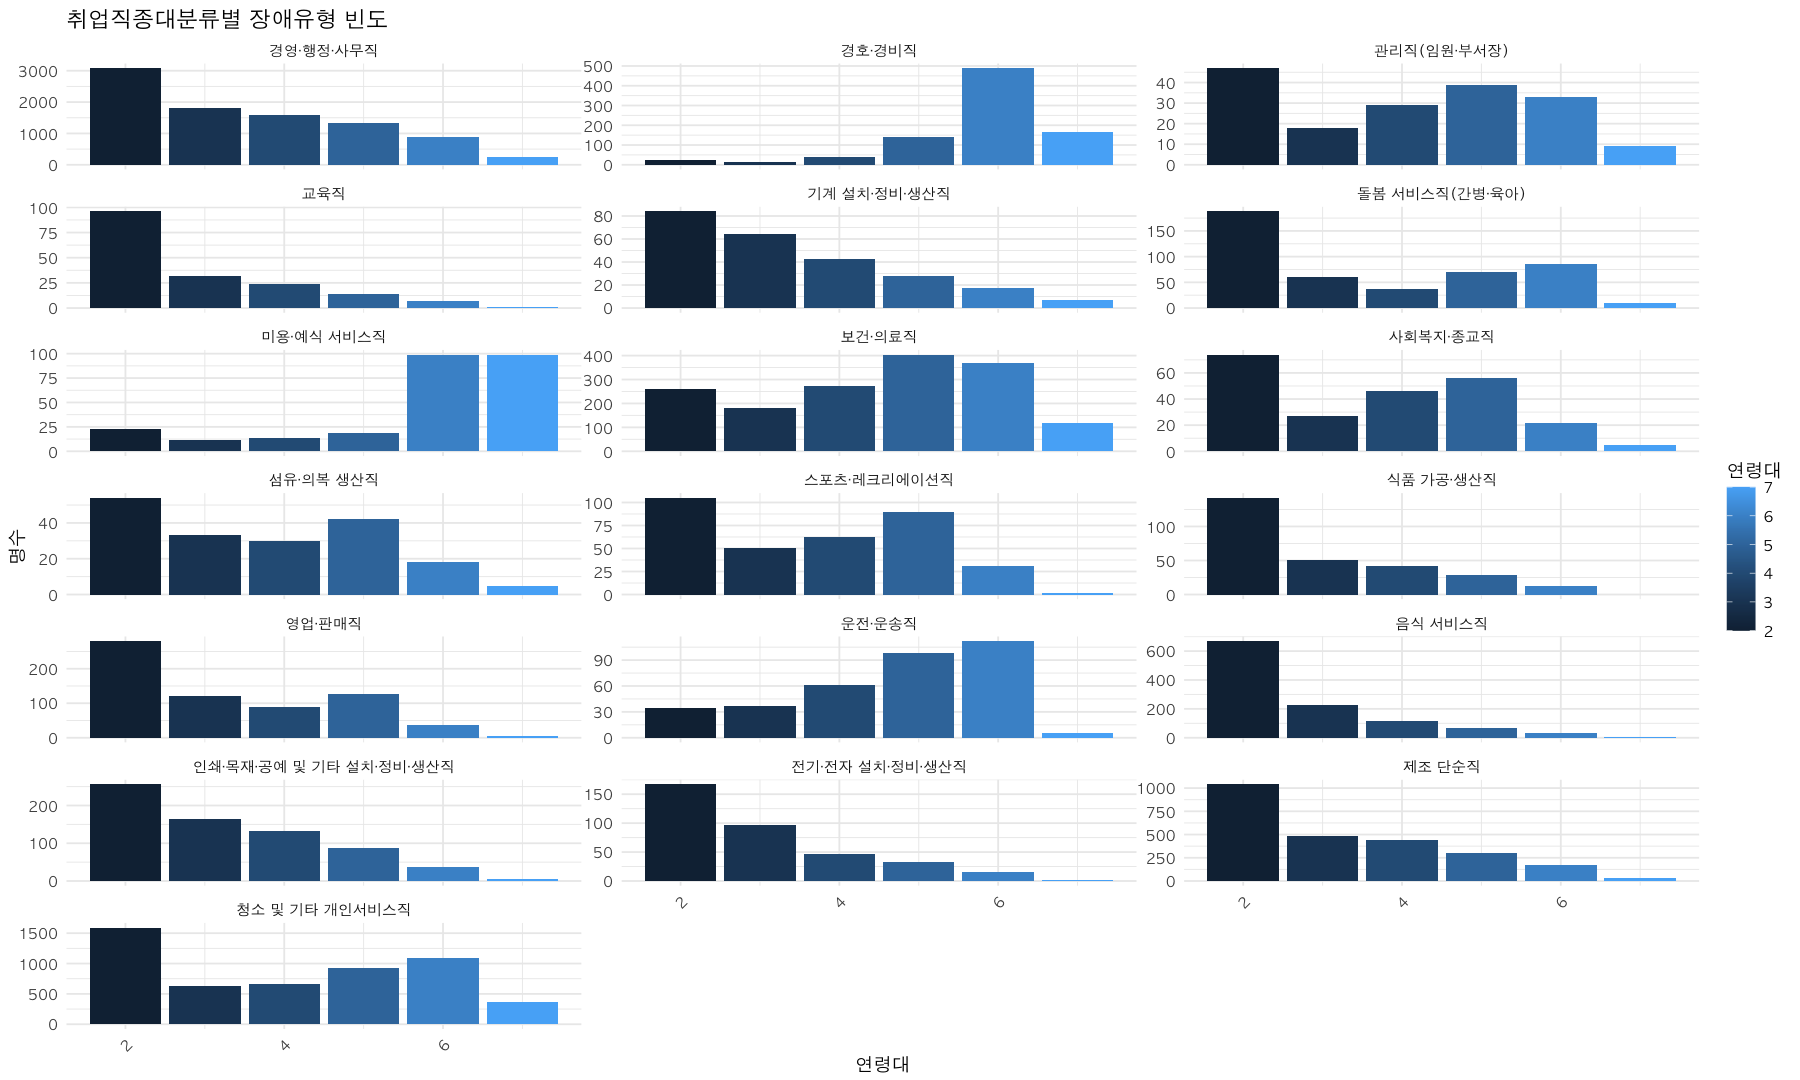

In [56]:
# 취업직종대분류별 연령대 빈도 계산
disable_freq_by_job_category_filtered <- refined_data_filtered_major5_subset %>%
  group_by(취업직종대분류, 연령대) %>%
  summarise(count = n())

# ggplot2를 사용하여 그래프 그리기 (그리드 레이아웃)
disable_freq_by_job_category_filtered <- ggplot(disable_freq_by_job_category_filtered, aes(x = 연령대, y = count, fill = 연령대)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "연령대", y = "명수", title = "취업직종대분류별 장애유형 빈도") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(family = "AppleGothic")) +
  facet_wrap(~ 취업직종대분류, ncol = 3, scales = "free_y")  # scales = "free_y"로 y축 범위 개별 설정

print(disable_freq_by_job_category_filtered)

In [57]:
head(refined_data_filtered_major5_subset)
str(refined_data_filtered_major5_subset)
summary(refined_data_filtered_major5_subset)

,취업일자,연령,장애유형,중증여부,근무지역,취업직종대분류,연령대,장애유형_중증여부
,<chr>,<int>,<chr>,<chr>,<fct>,<chr>,<dbl>,<fct>
1,2020-01-01,65,시각장애,중증,경북 경산시,경영·행정·사무직,6,시각장애-중증
2,2020-01-01,61,시각장애,중증,경북 고령군,경영·행정·사무직,6,시각장애-중증
3,2020-01-01,53,시각장애,경증,경북 의성군,경영·행정·사무직,5,시각장애-경증
4,2020-01-01,64,시각장애,중증,경북 성주군,경영·행정·사무직,6,시각장애-중증
5,2020-01-01,53,시각장애,경증,경북 군위군,경영·행정·사무직,5,시각장애-경증
6,2020-01-01,60,시각장애,중증,경북 영천시,경영·행정·사무직,6,시각장애-중증


'data.frame':	24711 obs. of  8 variables:
 $ 취업일자         : chr  "2020-01-01" "2020-01-01" "2020-01-01" "2020-01-01" ...
 $ 연령             : int  65 61 53 64 53 60 63 40 56 62 ...
 $ 장애유형         : chr  "시각장애" "시각장애" "시각장애" "시각장애" ...
 $ 중증여부         : chr  "중증" "중증" "경증" "중증" ...
 $ 근무지역         : Factor w/ 271 levels "","강원 강릉시",..: 98 100 115 107 102 112 109 120 19 18 ...
 $ 취업직종대분류   : chr  "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" ...
 $ 연령대           : num  6 6 5 6 5 6 6 4 5 6 ...
 $ 장애유형_중증여부: Factor w/ 32 levels "간장애-경증",..: 10 10 9 10 9 10 10 10 28 10 ...


   취업일자              연령         장애유형           중증여부        
 Length:24711       Min.   :20.00   Length:24711       Length:24711      
 Class :character   1st Qu.:26.00   Class :character   Class :character  
 Mode  :character   Median :40.00   Mode  :character   Mode  :character  
                    Mean   :41.62                                        
                    3rd Qu.:56.00                                        
                    Max.   :79.00                                        
                                                                         
          근무지역     취업직종대분류         연령대          장애유형_중증여부
 서울 송파구  :  663   Length:24711       Min.   :2.000   지적장애-중증:9094   
 서울 강남구  :  522   Class :character   1st Qu.:2.000   지체장애-경증:5691   
 서울 영등포구:  511   Mode  :character   Median :4.000   지체장애-중증:2680   
 서울 중구    :  480                      Mean   :3.748   정신장애-중증:1699   
 제주 제주시  :  405                      3rd Qu.:5.000   시각장애-중증:1508   
 서울 종로구  :  384    

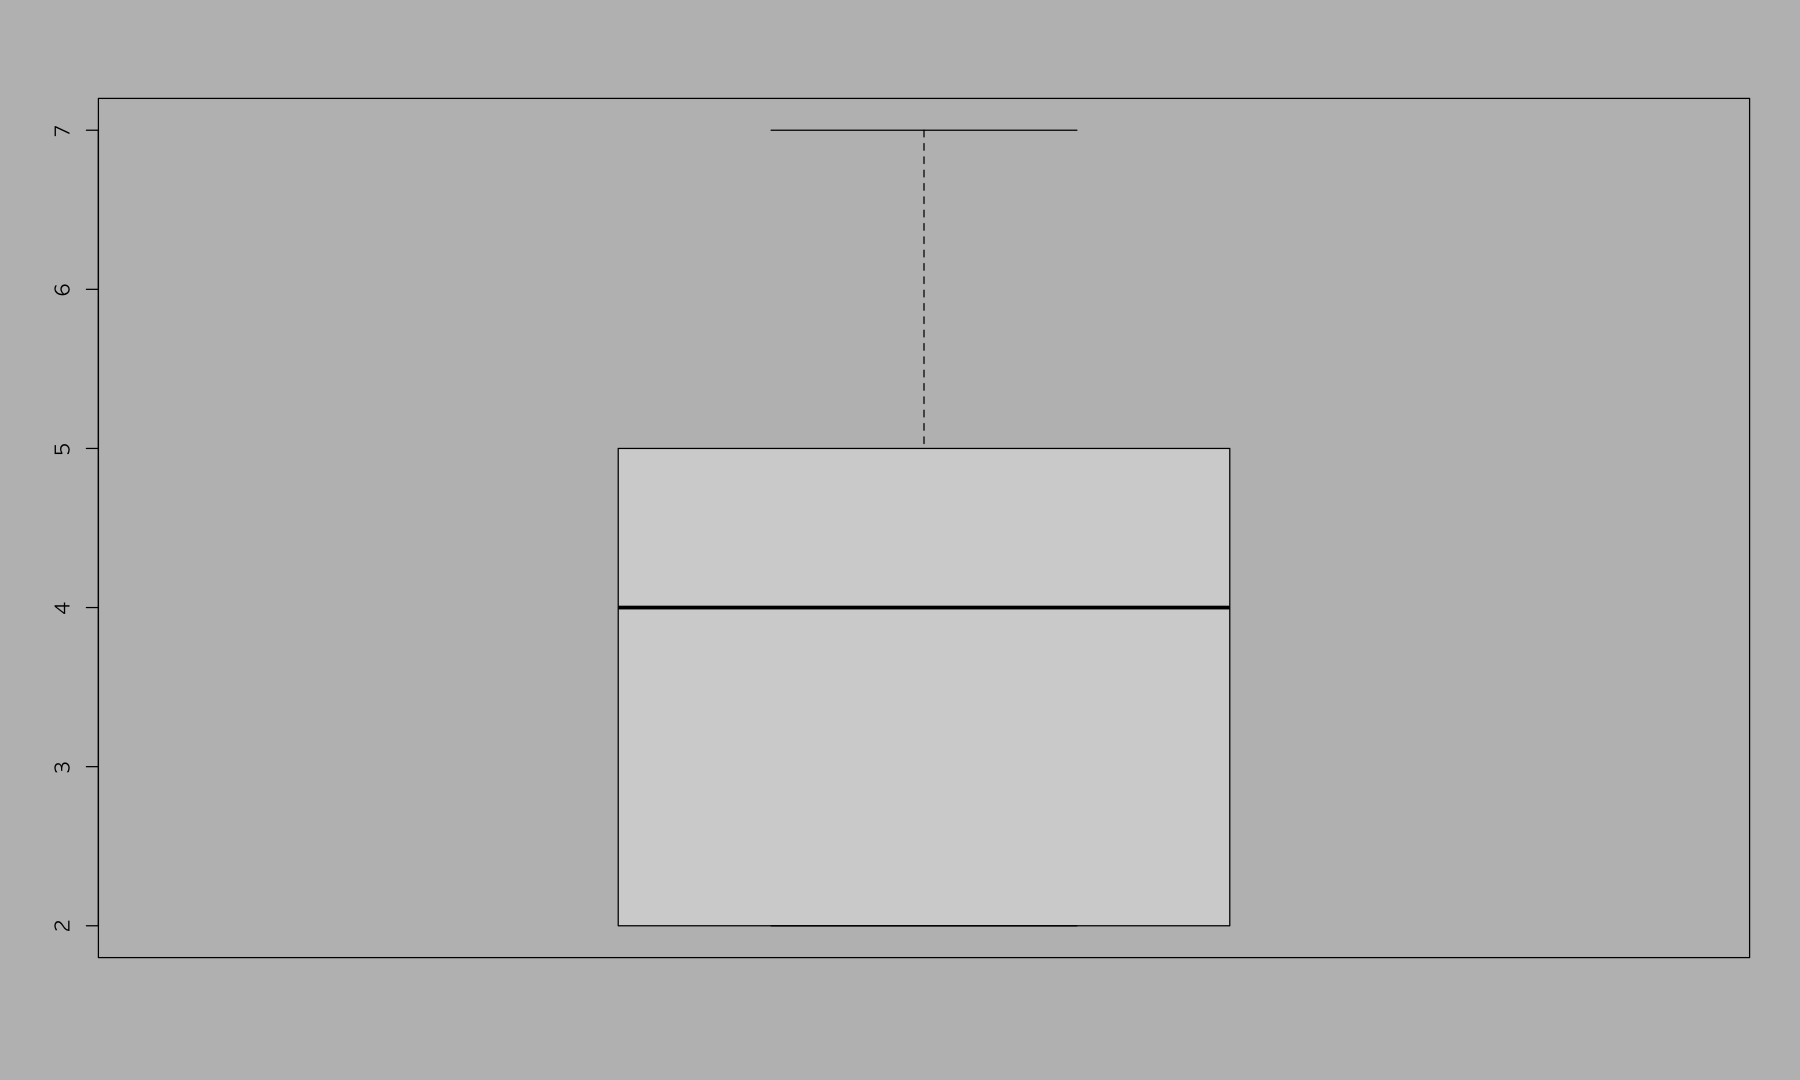

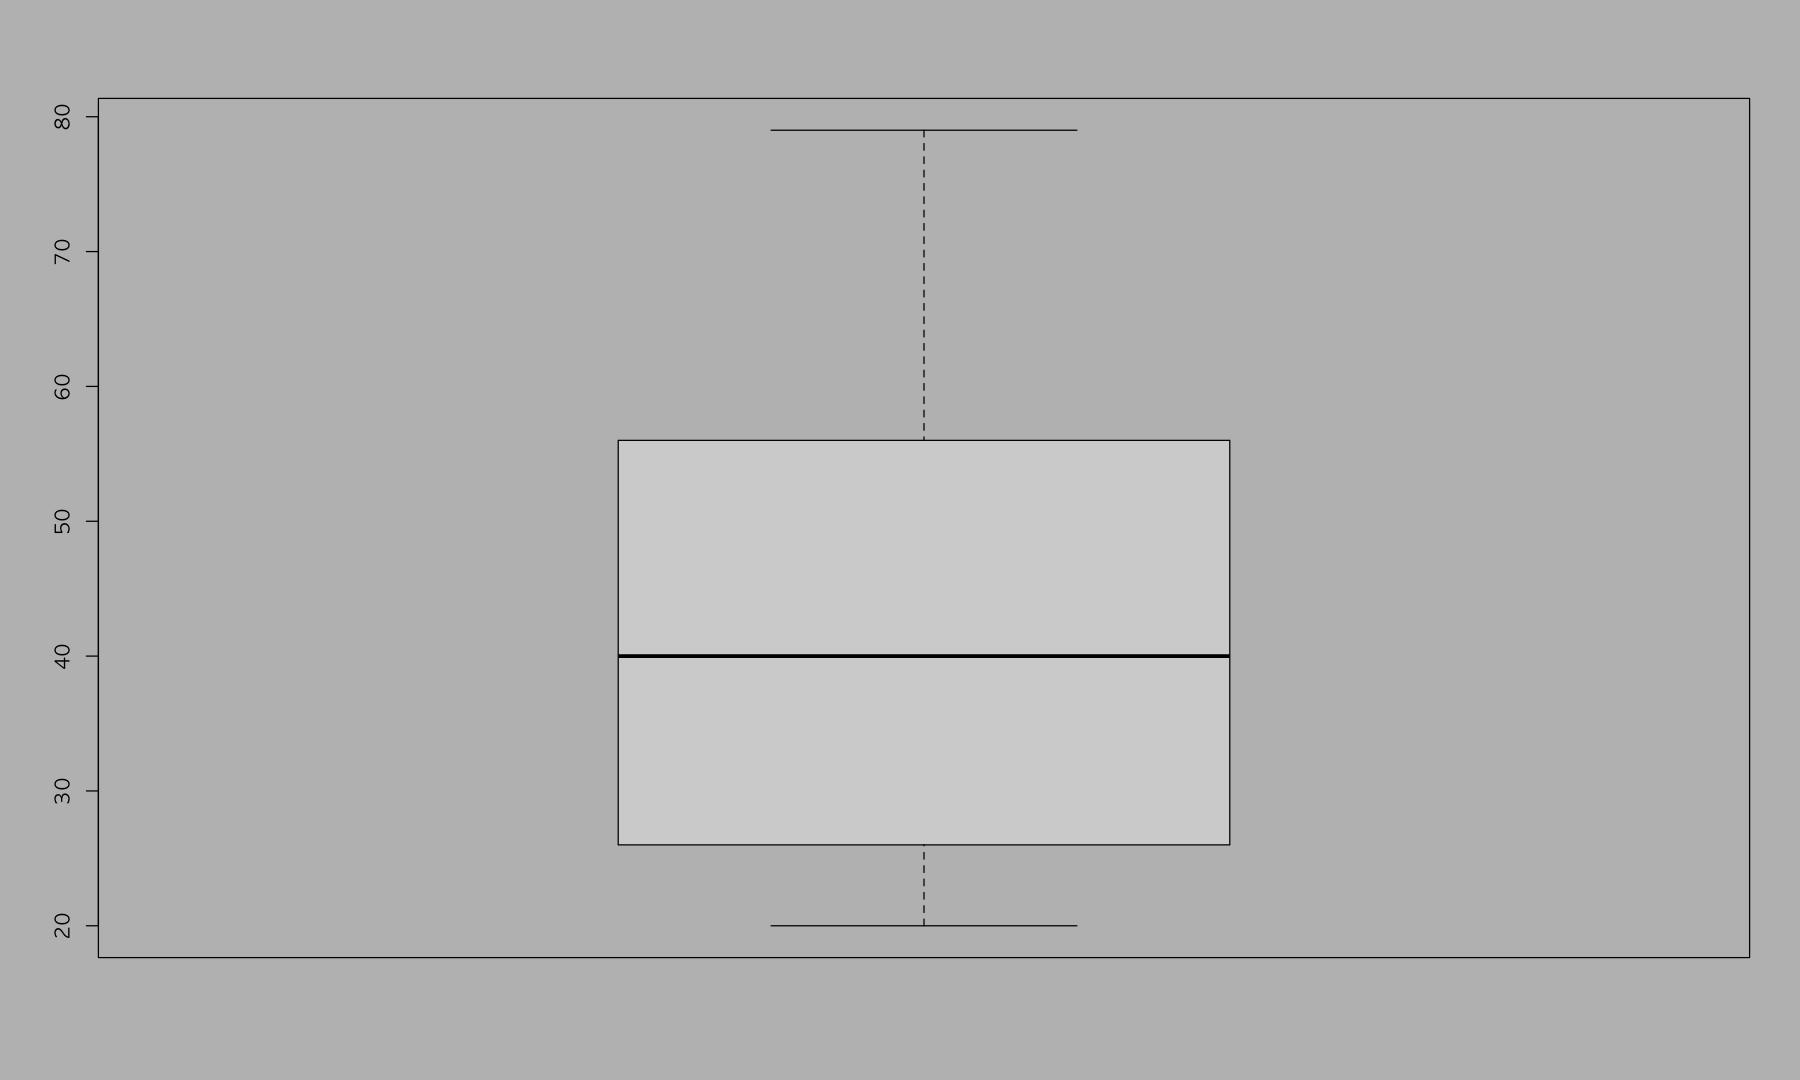

In [58]:
par(family="AppleGothic",bg="grey")
boxplot(refined_data_filtered_major5_subset$연령대)
boxplot(refined_data_filtered_major5_subset$연령)

In [59]:
# 취업일자를 월로 정제하여 새로운 열로 추가
refined_data_filtered_major5_subset$월 <- substr(refined_data_filtered_major5_subset$취업일자, 6, 7)

# 결과 확인
refined_data_filtered_major5_subset$월 <- factor(refined_data_filtered_major5_subset$월)
table(refined_data_filtered_major5_subset$장애유형_중증여부)
str(refined_data_filtered_major5_subset)


      간장애-경증       간장애-중증     국가유공-경증     국가유공-중증 
                0                 0                 0                 0 
  뇌병변장애-경증   뇌병변장애-중증   뇌전증장애-경증   뇌전증장애-중증 
                0                 0                 0                 0 
    시각장애-경증     시각장애-중증     신장장애-경증     신장장애-중증 
             1459              1508                 0                 0 
    심장장애-경증     심장장애-중증     안면장애-경증     안면장애-중증 
                0                 0                 0                 0 
    언어장애-경증     언어장애-중증   자폐성장애-경증   자폐성장애-중증 
                0                 0                 0                 0 
장루요루장애-경증 장루요루장애-중증     정신장애-경증     정신장애-중증 
                0                 0                 9              1699 
    지적장애-경증     지적장애-중증     지체장애-경증     지체장애-중증 
               25              9094              5691              2680 
    청각장애-경증     청각장애-중증   호흡기장애-경증   호흡기장애-중증 
             1085              1461                 0                 0 

'data.frame':	24711 obs. of  9 variables:
 $ 취업일자         : chr  "2020-01-01" "2020-01-01" "2020-01-01" "2020-01-01" ...
 $ 연령             : int  65 61 53 64 53 60 63 40 56 62 ...
 $ 장애유형         : chr  "시각장애" "시각장애" "시각장애" "시각장애" ...
 $ 중증여부         : chr  "중증" "중증" "경증" "중증" ...
 $ 근무지역         : Factor w/ 271 levels "","강원 강릉시",..: 98 100 115 107 102 112 109 120 19 18 ...
 $ 취업직종대분류   : chr  "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" ...
 $ 연령대           : num  6 6 5 6 5 6 6 4 5 6 ...
 $ 장애유형_중증여부: Factor w/ 32 levels "간장애-경증",..: 10 10 9 10 9 10 10 10 28 10 ...
 $ 월               : Factor w/ 12 levels "01","02","03",..: 1 1 1 1 1 1 2 3 7 1 ...


`summarise()` has grouped output by '취업직종대분류'. You can override using
the `.groups` argument.


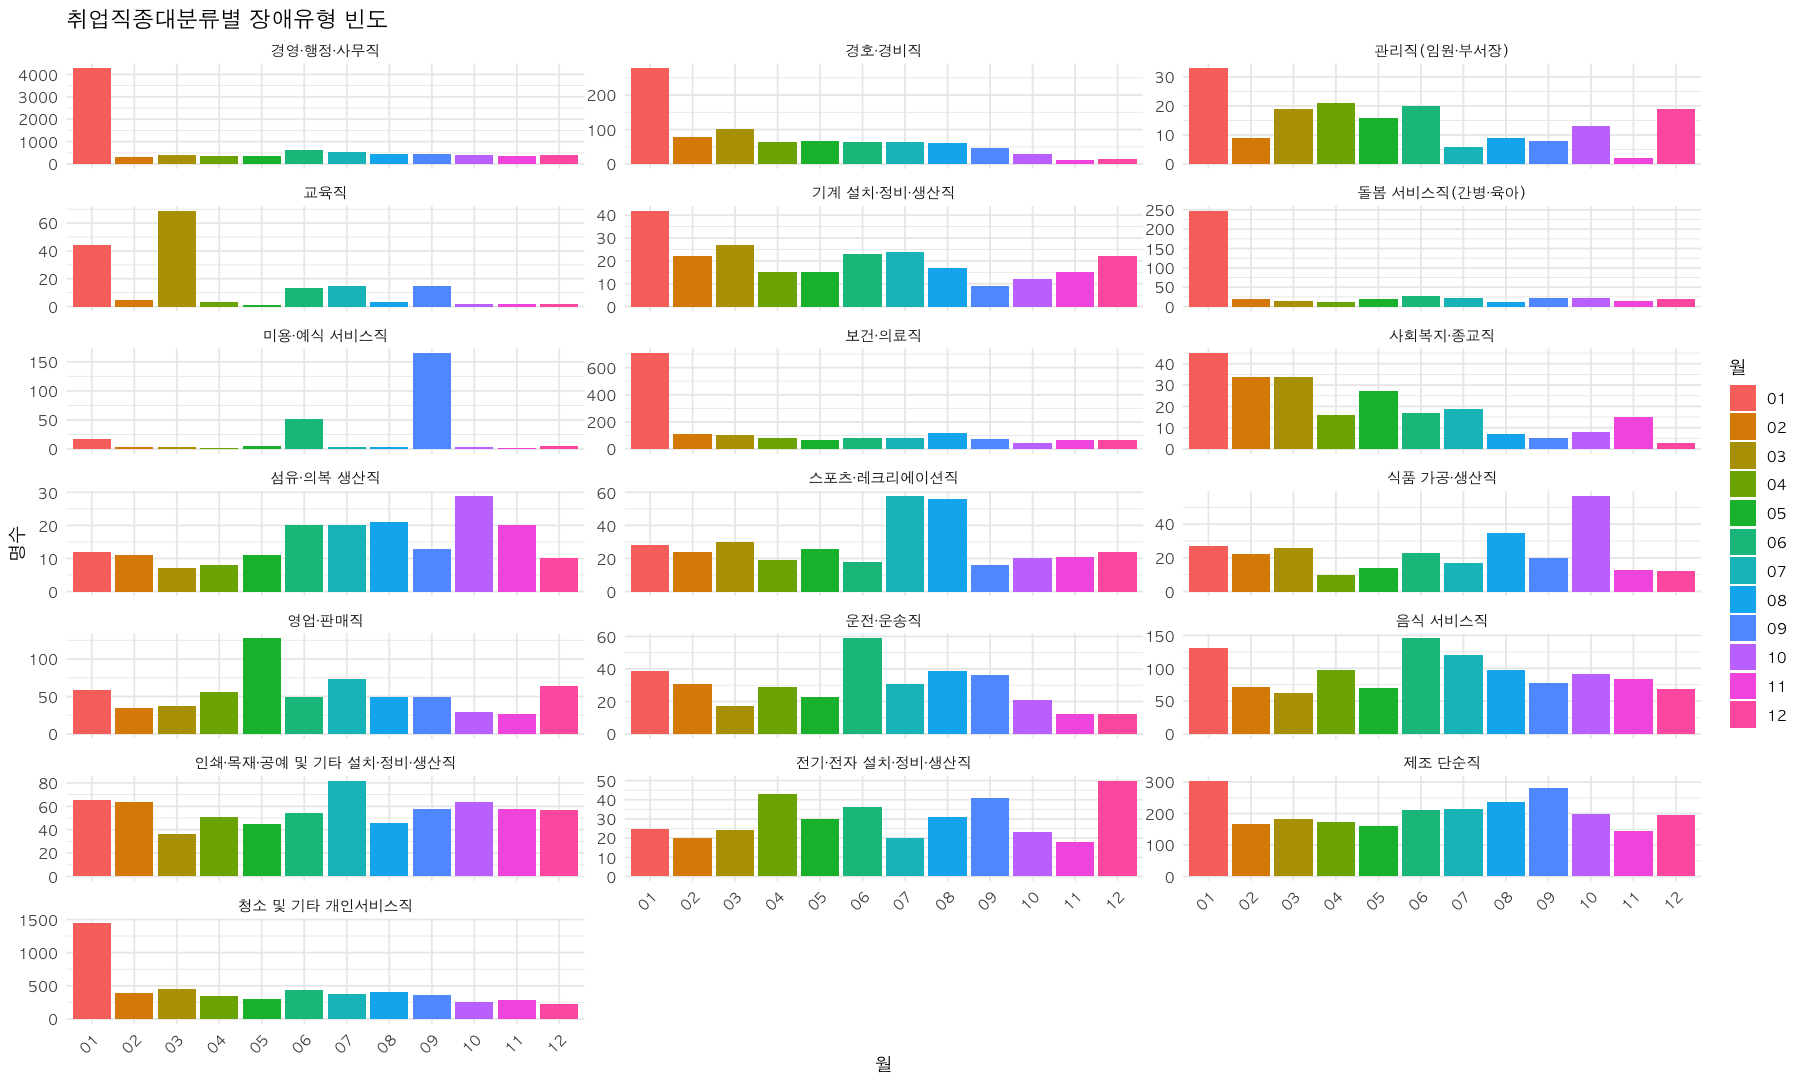

In [60]:
# 취업직종대분류별 월별 빈도 계산
month_freq_by_job_category_filtered <- refined_data_filtered_major5_subset %>%
  group_by(취업직종대분류, 월) %>%
  summarise(count = n())

# ggplot2를 사용하여 그래프 그리기 (그리드 레이아웃)
month_freq_by_job_category_filtered <- ggplot(month_freq_by_job_category_filtered, aes(x = 월, y = count, fill = 월)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "월", y = "명수", title = "취업직종대분류별 장애유형 빈도") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(family = "AppleGothic")) +
  facet_wrap(~ 취업직종대분류, ncol = 3, scales = "free_y")  # scales = "free_y"로 y축 범위 개별 설정

print(month_freq_by_job_category_filtered)

In [61]:
refined_data_filtered_major5_subset

,취업일자,연령,장애유형,중증여부,근무지역,취업직종대분류,연령대,장애유형_중증여부,월
,<chr>,<int>,<chr>,<chr>,<fct>,<chr>,<dbl>,<fct>,<fct>
1,2020-01-01,65,시각장애,중증,경북 경산시,경영·행정·사무직,6,시각장애-중증,01
2,2020-01-01,61,시각장애,중증,경북 고령군,경영·행정·사무직,6,시각장애-중증,01
3,2020-01-01,53,시각장애,경증,경북 의성군,경영·행정·사무직,5,시각장애-경증,01
4,2020-01-01,64,시각장애,중증,경북 성주군,경영·행정·사무직,6,시각장애-중증,01
5,2020-01-01,53,시각장애,경증,경북 군위군,경영·행정·사무직,5,시각장애-경증,01
6,2020-01-01,60,시각장애,중증,경북 영천시,경영·행정·사무직,6,시각장애-중증,01
7,2020-02-01,63,시각장애,중증,경북 영덕군,경영·행정·사무직,6,시각장애-중증,02
8,2020-03-02,40,시각장애,중증,경북 포항시,보건·의료직,4,시각장애-중증,03
9,2020-07-01,56,지체장애,중증,강원 횡성군,보건·의료직,5,지체장애-중증,07


In [62]:
# refined_data_filtered_major5_subset를 .csv 파일로 저장
write.csv(refined_data_filtered_major5_subset, file = "refined_data_filtered_major5_subset.csv", row.names = FALSE)

In [63]:
# 근무지역분류 컬럼 생성
refined_data_filtered_major5_subset$근무지역분류 <- substr(refined_data_filtered_major5_subset$근무지역, 1, 2)

In [64]:
table(refined_data_filtered_major5_subset$근무지역분류)


     강원 경기 경남 경북 광주 대구 대전 부산 서울 세종 울산 인천 전남 전북 제주 
   1  929 4704 1624 1240 1010 1022  812 1604 5268   94  735 1292  977  873  471 
충남 충북 
1008 1047 

In [65]:
table(refined_data_filtered_major5_subset$근무지역분류)
refined_data_filtered_major5_subset$근무지역분류 <- gsub("''| ", NA, refined_data_filtered_major5_subset$근무지역분류)
sum(is.na(refined_data_filtered_major5_subset$근무지역분류))


     강원 경기 경남 경북 광주 대구 대전 부산 서울 세종 울산 인천 전남 전북 제주 
   1  929 4704 1624 1240 1010 1022  812 1604 5268   94  735 1292  977  873  471 
충남 충북 
1008 1047 

[1] 0

In [66]:
# 변경하고자 하는 근무지역 목록을 생성합니다.
valid_regions <- c('경북', '강원', '전남', '충북', '경기', '인천', '서울', '울산', '대전', '부산', '전북', '광주', '충남', '대구', '경남', '제주', '세종')

# 근무지역분류 열에 해당하지 않는 값들을 NA로 변경합니다.
refined_data_filtered_major5_subset$근무지역분류[!refined_data_filtered_major5_subset$근무지역분류 %in% valid_regions] <- NA

refined_data_filtered_major5_subset<-na.omit(refined_data_filtered_major5_subset)
# 변경 결과 확인
table(refined_data_filtered_major5_subset$근무지역분류)



강원 경기 경남 경북 광주 대구 대전 부산 서울 세종 울산 인천 전남 전북 제주 충남 
 929 4704 1624 1240 1010 1022  812 1604 5268   94  735 1292  977  873  471 1008 
충북 
1047 

In [67]:
# 중복값을 제외한 근무지역 값 얻기
unique_work_locations <- unique(refined_data_filtered_major5_subset$근무지역)

# 각 근무지역의 앞의 두 글자 추출
first_two_letters <- substring(unique_work_locations, 1, 2)
unique(first_two_letters)
length(unique(first_two_letters))


[1] "경북" "강원" "전남" "충북" "경기" "인천" "서울" "울산" "대전" "부산"
[11] "전북" "광주" "충남" "대구" "경남" "제주" "세종"

[1] 17

In [68]:
refined_data_filtered_major5_subset$근무지역분류 <-as.factor(refined_data_filtered_major5_subset$근무지역분류)
str(refined_data_filtered_major5_subset)


'data.frame':	24710 obs. of  10 variables:
 $ 취업일자         : chr  "2020-01-01" "2020-01-01" "2020-01-01" "2020-01-01" ...
 $ 연령             : int  65 61 53 64 53 60 63 40 56 62 ...
 $ 장애유형         : chr  "시각장애" "시각장애" "시각장애" "시각장애" ...
 $ 중증여부         : chr  "중증" "중증" "경증" "중증" ...
 $ 근무지역         : Factor w/ 271 levels "","강원 강릉시",..: 98 100 115 107 102 112 109 120 19 18 ...
 $ 취업직종대분류   : chr  "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" "경영·행정·사무직" ...
 $ 연령대           : num  6 6 5 6 5 6 6 4 5 6 ...
 $ 장애유형_중증여부: Factor w/ 32 levels "간장애-경증",..: 10 10 9 10 9 10 10 10 28 10 ...
 $ 월               : Factor w/ 12 levels "01","02","03",..: 1 1 1 1 1 1 2 3 7 1 ...
 $ 근무지역분류     : Factor w/ 17 levels "강원","경기",..: 4 4 4 4 4 4 4 4 1 1 ...
 - attr(*, "na.action")= 'omit' Named int 157
  ..- attr(*, "names")= chr "185"


In [69]:
sum(is.na(refined_data_filtered_major5_subset$근무지역분류))

[1] 0

In [70]:
# refined_data_filtered_major5_subset를 .csv 파일로 저장
write.csv(refined_data_filtered_major5_subset, file = "refined_data_filtered_major5_subset.csv", row.names = FALSE)

`summarise()` has grouped output by '취업직종대분류'. You can override using
the `.groups` argument.


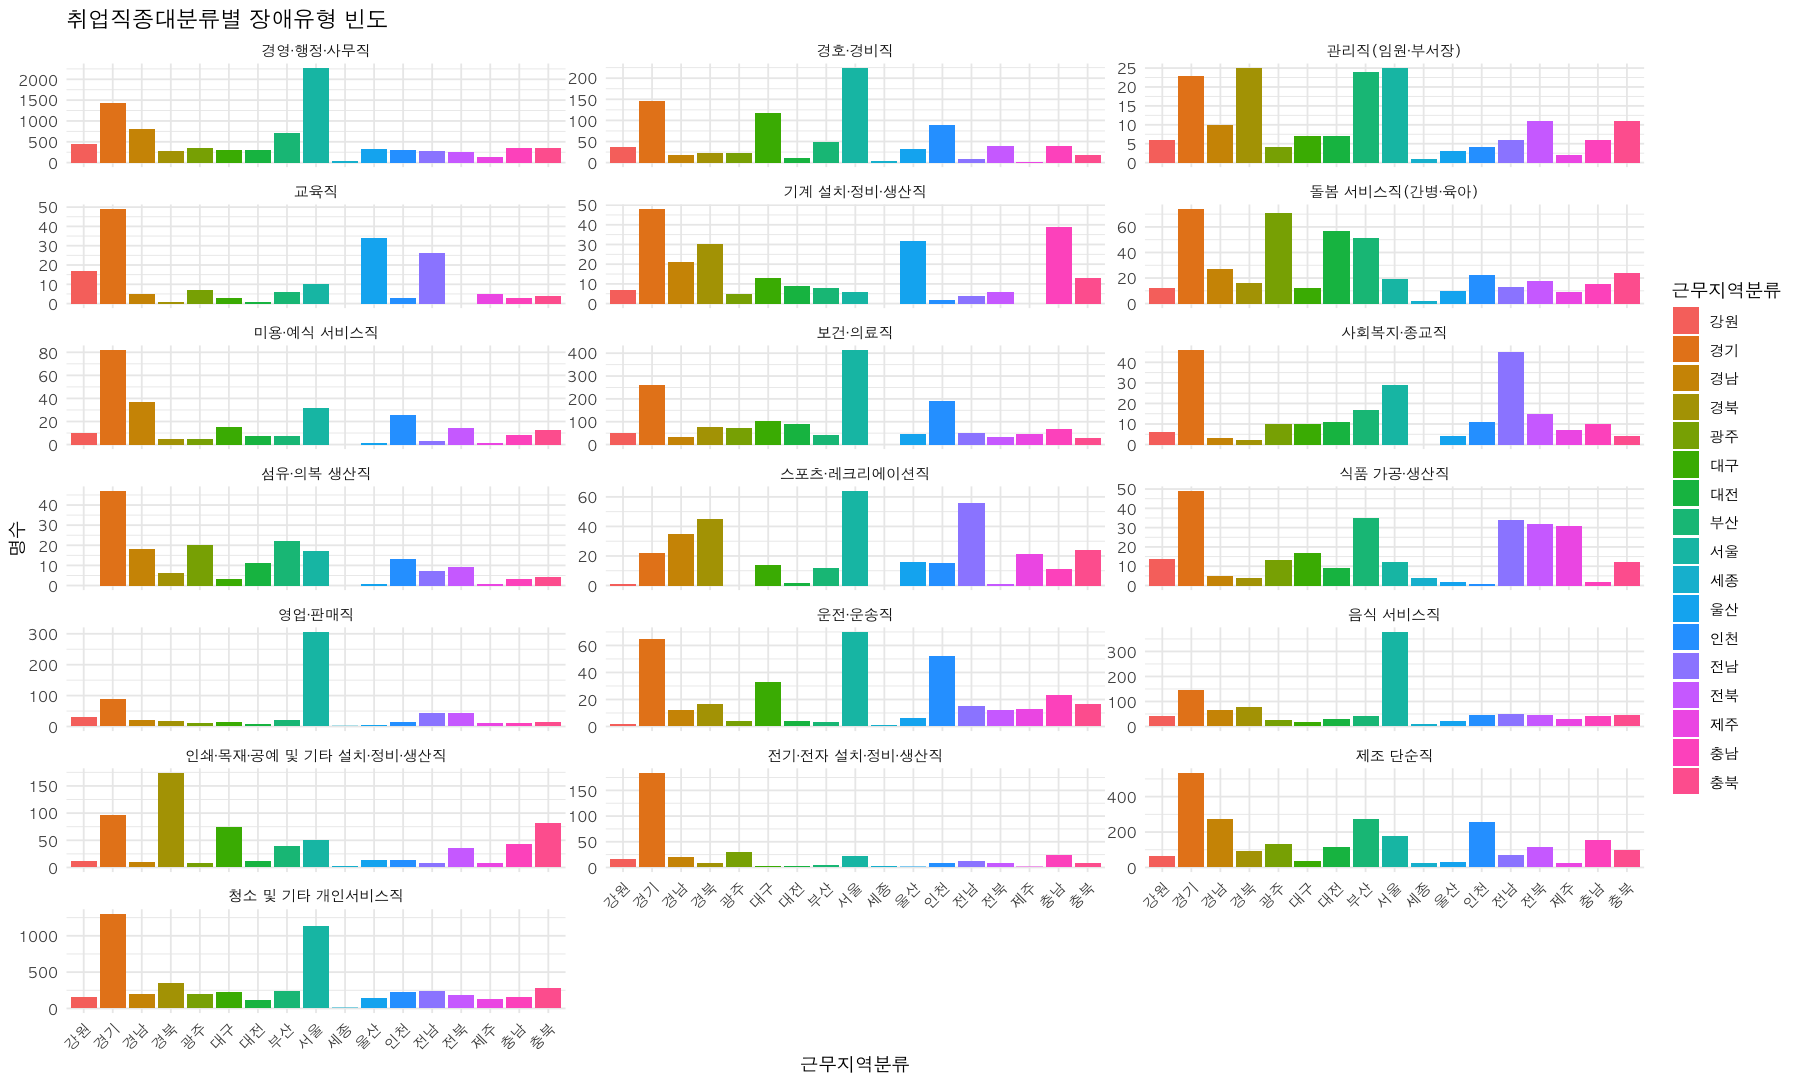

In [71]:
# 취업직종대분류별 지역별 빈도 계산
local_freq_by_job_category_filtered <- refined_data_filtered_major5_subset %>%
  group_by(취업직종대분류, 근무지역분류) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# ggplot2를 사용하여 그래프 그리기 (그리드 레이아웃)
local_freq_by_job_category_filtered <- ggplot(local_freq_by_job_category_filtered, aes(x = 근무지역분류, y = count, fill = 근무지역분류)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "근무지역분류", y = "명수", title = "취업직종대분류별 장애유형 빈도") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(family = "AppleGothic")) +
  facet_wrap(~ 취업직종대분류, ncol = 3, scales = "free_y")  # scales = "free_y"로 y축 범위 개별 설정

print(local_freq_by_job_category_filtered)

In [72]:
head(sort(table(refined_data_filtered_major5_subset$근무지역분류), decreasing = TRUE))


서울 경기 경남 부산 인천 경북 
5268 4704 1624 1604 1292 1240 

In [73]:
head(sort(table(refined_data_filtered_major5_subset$월), decreasing = TRUE))


  01   06   07   09   08   03 
7830 1998 1791 1735 1682 1661 